In [3]:
import random
import csv

import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from matplotlib import pyplot as plt
import sys

from utils.training.metrics import accuracy_for_segmenter
from utils.training.data_loading import lines_to_line_generator, get_line_to_spectro_seg
from utils.training.keras_models import time_segmenter_model

In [10]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/training/spectrograms"
SEED = 0
BATCH_SIZE = 64
EPOCHS = 50
CHECKPOINTS_DIR = "checkpoints_seg"

FOLDS = 5
SIZE = (128, 186)  # number of pixels in the spectrograms
CHANNELS = 1  # 1 means grayscale 3 RGB
DURATION_S = 100  # duration of the spectrograms in s
OBJECTIVE_CURVE_WIDTH = 10  # defines dispersion of objective function in s

data_loader = get_line_to_spectro_seg(size=SIZE, duration_s=DURATION_S, channels=CHANNELS, objective_curve_width=OBJECTIVE_CURVE_WIDTH)
model = time_segmenter_model

In [5]:
with open(ROOT_DIR + "/dataset.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    lines = list(csv_reader)
print(len(lines), "files found")

pos = [l for l in lines if l[1]=="positive"]
neg = [l for l in lines if l[1]=="negative"]
random.Random(SEED).shuffle(pos)
random.Random(SEED).shuffle(neg)
print(f"{len(pos)} positive files found and {len(neg)} negative files found")

train_datasets, valid_datasets = [], []
for i in range(FOLDS):
    start_valid_idx = int(len(pos) * i / FOLDS)
    end_valid_idx = int(len(pos) * (i + 1) / FOLDS)
    train_files = pos[:start_valid_idx]+pos[end_valid_idx:]+neg[:start_valid_idx]+neg[end_valid_idx:] # unbalanced training set
    valid_files = pos[start_valid_idx:end_valid_idx]+neg[start_valid_idx:end_valid_idx] # balanced validation set
    random.Random(SEED).shuffle(train_files)
    random.Random(SEED).shuffle(valid_files)
    train_generator = lines_to_line_generator(train_files)
    valid_generator = lines_to_line_generator(valid_files)
    train_datasets.append(tf.data.Dataset.from_generator(lambda: map(tuple, train_generator), output_signature=tf.TensorSpec(shape=[None], dtype=tf.string)))
    valid_datasets.append(tf.data.Dataset.from_generator(lambda: map(tuple, valid_generator), output_signature=tf.TensorSpec(shape=[None], dtype=tf.string)))
    
    train_datasets[-1] = train_datasets[-1].map(data_loader).batch(batch_size=BATCH_SIZE)
    valid_datasets[-1] = valid_datasets[-1].map(data_loader).batch(batch_size=BATCH_SIZE)
    
all_train_files = pos + neg
random.Random(SEED).shuffle(all_train_files)
all_train_generator = lines_to_line_generator(all_train_files)
all_train_dataset =tf.data.Dataset.from_generator(lambda: map(tuple, all_train_generator), output_signature=tf.TensorSpec(shape=[None], dtype=tf.string))
all_train_dataset = all_train_dataset.map(data_loader).batch(batch_size=BATCH_SIZE)

33919 files found
9229 positive files found and 24690 negative files found


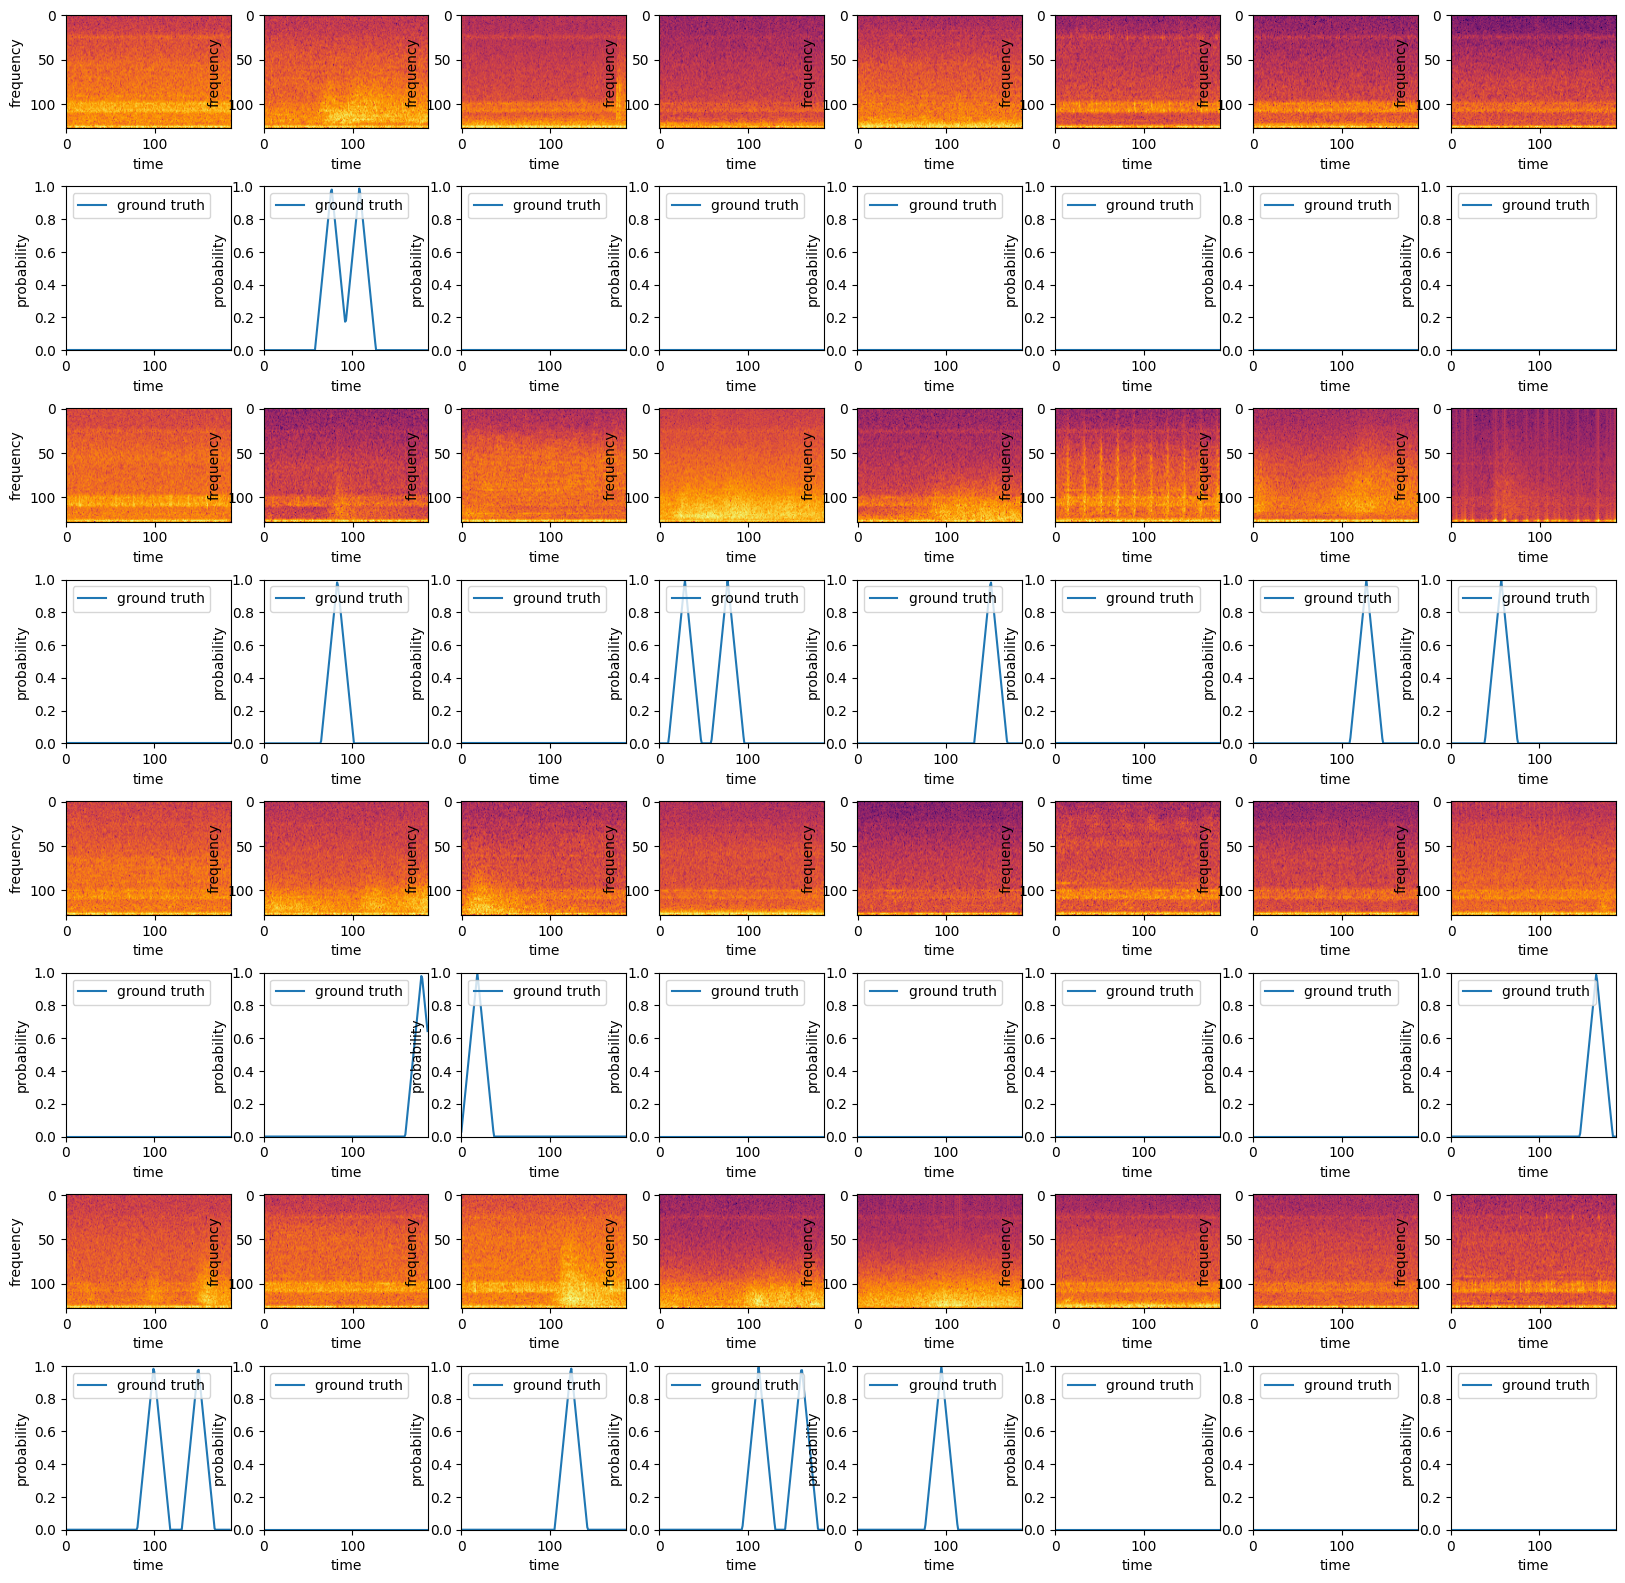

In [6]:
cols = 8
lines = 4
batch_number = 1  # number of the batch we want to inspect

to_show = cols * lines
plt.figure(figsize=(cols*2.5, lines*5))
shown=0
for images, y in valid_datasets[0].take(batch_number+to_show//BATCH_SIZE+1):
    if batch_number:
            batch_number -= 1
            continue
    for i in range(min(BATCH_SIZE, to_show-shown)):
        ax1 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols))
        plt.xlabel("time")
        plt.ylabel("frequency")
        plt.imshow(images[i].numpy(), cmap='inferno')

        ax2 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols) + cols)

        ax2.plot(y[i], label='ground truth')
        ax2.legend(loc="upper left")
        ax2.set_xlim([0, SIZE[1]])
        ax2.set_ylim([0, 1])
        ax2.set_xlabel("time")
        ax2.set_ylabel("probability")

        shown += 1
plt.show()

In [13]:
import os, pickle

for i in range(FOLDS):
    path_prefix = f'{CHECKPOINTS_DIR}/FOLD-{i}'
    history_file = f'{path_prefix}/history.pkl'
    
    if os.path.isfile(history_file):
        print(f"fold {i} already has an history file, skipping it")
        continue
        
    print(f"starting training of fold {i}")
    m = model()

    m.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.losses.binary_crossentropy,
            metrics=accuracy_for_segmenter)

    m.build((BATCH_SIZE, SIZE[0], SIZE[1], 1))

    if i==0:
        m.summary()

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{path_prefix}/cp-{{epoch:04d}}.ckpt', save_weights_only=True, verbose=1)

    history = m.fit(
            train_datasets[i],
            batch_size=BATCH_SIZE,
            validation_data=valid_datasets[i],
            steps_per_epoch=len(train_files) // BATCH_SIZE,
            validation_steps=len(valid_files) // BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[cp_callback]
        )
    
    with open(history_file, 'wb') as f:
        pickle.dump(history.history, f)



m = model()

m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.losses.binary_crossentropy,
        metrics=accuracy_for_segmenter)

m.build((BATCH_SIZE, SIZE[0], SIZE[1], 1))

m.summary()

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="{CHECKPOINTS_DIR}/cp-{epoch:04d}.ckpt",
                                                     save_weights_only=True,
                                                     verbose=1)

m.fit(
        all_train_dataset,
        batch_size=BATCH_SIZE,
        steps_per_epoch=(len(train_files) + len(valid_files))// BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[cp_callback]
    )

starting training of fold 0
Model: "time_segmenter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 rescaling_3 (Rescaling)     (None, None, None, 1)     0         
                                                                 
 conv2d_39 (Conv2D)          (None, None, None, 16)    1040      
                                                                 
 conv2d_40 (Conv2D)          (None, None, None, 16)    16400     
                                                                 
 conv2d_41 (Conv2D)          (None, None, None, 16)    16400     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, None, None, 16)    0         
 ng2D)                                                           
                        


KeyboardInterrupt



In [ ]:
model.load_weights(f"{CHECKPOINTS_DIR}/cp-0013.ckpt")

In [ ]:
cols = 8
lines = 8
batch_number = 0

to_show = cols * lines
plt.figure(figsize=(20, lines*5))
shown=0
for images, y in valid_dataset.take(batch_number+to_show//BATCH_SIZE+1):
    if batch_number:
            batch_number -= 1
            continue
    for i in range(min(BATCH_SIZE, to_show-shown)):
        ax1 = plt.subplot(lines*2, cols, 1 + i%cols + cols*2*(i//cols))
        plt.xlabel("time (s)")
        plt.ylabel("frequency (Hz)")
        plt.imshow(images[i].numpy(), cmap='inferno')

        ax2 = plt.subplot(lines*2, cols, 1 + i%cols + cols*2*(i//cols) + cols)
        
        ax2.plot(y[i], label='ground truth')
        predicted = model.predict(np.reshape(images[i], (1, SIZE[0], SIZE[1], 1)), verbose=False)[0]
        ax2.plot(predicted, label='predicted')
        ax2.legend(loc="upper left")
        ax2.set_xlim([0, SIZE[1]])
        ax2.set_ylim([0, 1])
        ax2.set_xlabel("time (s)")
        ax2.set_ylabel("probability")

        shown += 1
plt.show()